In [1]:
# import preprocess as prep
import SLR_model
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time
import os
import json
import importlib
from matplotlib import pyplot as plt
import preprocess

# model will output multiple(15) results/sec, how are we gonna handle it?

In [2]:
 # reload model file
importlib.reload(SLR_model)
importlib.reload(preprocess)

<module 'SLR_model' from 'c:\\Users\\jerry\\Desktop\\hly\\2024-2\\cap\\BN_SLR\\BomNae-SLR\\SLR_model.py'>

In [3]:
# utility functions

def bin2num(bin_arr):
    # big endian
    # lower index > higher exponent
    num = 0
    for val in bin_arr:
        num = (num << 1) | val
    return num

# def num2bin(num, arr_len = -1):
#     # big endian
#     # lower index > higher exponent
#     bin_arr = [int(x) for x in bin(num)[2:]]
#     diff = arr_len - len(bin_arr)
#     if diff < 1:
#         return bin_arr
#     else:
#         pad = [0] * diff
#         return pad+bin_arr
    
def num_arr2bin(num_arr, out_len = -1):
    # big endian
    # lower index > higher exponent
    res = []
    for num in num_arr:
        str_list = list(np.binary_repr(num).zfill(out_len))
        bin_arr = np.array(str_list, dtype=np.float32)
        res.append(bin_arr)
    return np.array(res)

def serialize(vids, stride = 1):
    """input shape: (load_size, frames)\n
    ouput shape: (load_size, input_seq_size, 63 or 32, frames)"""
    each_size = []
    x_res = []
    for vid in vids:
        window_len = 0
        start = 0
        while (start + 63) < len(vid):
            x_res.append(vid[start: start+63: stride])
            window_len += 1
            start += 6
        each_size.append(window_len)
    return np.array(x_res), each_size

In [4]:
# Configurations
load_size = 256 # number of data to be loaded at once
epochs = 10
batch_size = 16
save_dir = "saves"
load_dir = "saves"
# load_path = "C:/Users/jerry/Desktop/hly/2024-2/cap/BN_SLR/BomNae-SLR/checkpoints.keras"


In [5]:
# # dummy x_raw data
# l_raw = []
# duration_list = []
# for i in range(load_size):
#     h_elem = np.zeros(shape=(4,5,3))
#     # p_elem = np.zeros(shape=(3,10))
#     # comb_elem = [h_elem, h_elem, p_elem]
#     x_elem = []
#     duration = (np.random.randint(70,91))
#     duration_list.append(duration)
#     for j in range(duration): # frame size
#         x_elem.append(h_elem)
#         # x_elem.append(comb_elem)
#     l_raw.append(x_elem)
# r_raw = []
# for i in range(load_size):
#     h_elem = np.zeros(shape=(4,5,3))
#     # p_elem = np.zeros(shape=(3,10))
#     # comb_elem = [h_elem, h_elem, p_elem]
#     x_elem = []
#     duration = duration_list[i]
#     for j in range(duration): # frame size
#         x_elem.append(h_elem)
#         # x_elem.append(comb_elem)
#     r_raw.append(x_elem)
# p_raw = []
# for i in range(load_size):
#     # h_elem = np.zeros(shape=(4,5,3))
#     p_elem = np.zeros(shape=(3,10))
#     # comb_elem = [h_elem, h_elem, p_elem]
#     x_elem = []
#     duration = duration_list[i]
#     for j in range(duration): # frame size
#         # x_elem.append(h_elem)
#         x_elem.append(p_elem)
#         # x_elem.append(comb_elem)
#     p_raw.append(x_elem)

# # dummy y_raw data
# # y_raw = np.random.randint(0,1024,load_size)
# y_raw = np.zeros(shape=(load_size,), dtype=np.int32)

In [32]:
l_raw, r_raw, p_raw, y_raw ,check_raw= preprocess.load_word(1,1,load_size)

In [6]:
l_train, each = serialize(l_raw)
r_train, each = serialize(r_raw)
p_train, each = serialize(p_raw, stride=2)
y_train = np.repeat(y_raw, each)
y_train = num_arr2bin(y_train, 12)

In [7]:
# hand input shape: (batch, time, h, w, channels)
# pose input shape: (batch, time, channel, features)

In [8]:
x_train = (l_train, r_train, p_train)

In [9]:
model = SLR_model.get_model()

In [33]:
# # 세이브된 모델 로드
# load_path = os.join(load_dir, "check_00-00-00.keras")
# model = SLR_model.load_model(load_path)

In [11]:
# # 안될때 (강제중지 + 초기화)
# tf.keras.backend.clear_session()

In [12]:
# hist = model.fit(x_train, y_train, epochs=epochs, batch_size= batch_size, callbacks=[model_checkpoint_callback])

In [13]:
dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size)

In [14]:
save_suffix = time.strftime("_%d-%H-%M", time.localtime(time.time()))
check_path = os.path.join(save_dir, "check"+save_suffix)
hist_path = os.path.join(save_dir, "hist"+save_suffix+".json")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=f'{check_path}.keras',
    monitor='binary_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True)

hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])

with open(hist_path, 'w') as file:
    json.dump(hist.history, file)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9497 - loss: 0.6744
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 1.0000 - loss: 0.3924
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 1.0000 - loss: 0.0488
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 1.0000 - loss: 0.0087
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 1.0000 - loss: 0.0037
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 1.0000 - loss: 0.0021
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 1.0000 - loss: 0.0014
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 1.0000 - loss: 9.4867e-04
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 1.0000 - loss: 7.0117e-04
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 1.0000 - loss: 5.3909e-04


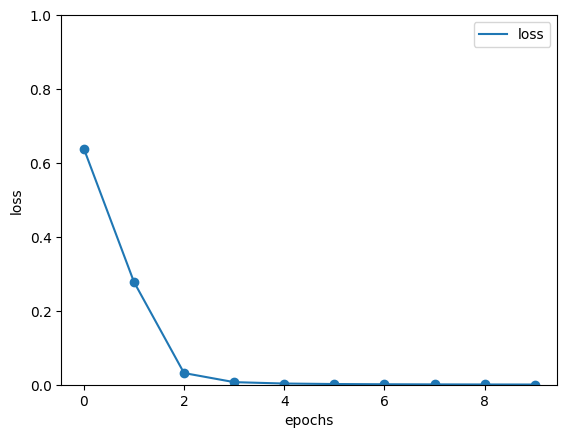

In [15]:
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.scatter(range(len(hist.history['loss'])), hist.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["loss"])
plt.ylim((0,1))
plt.show()

In [84]:
# importlib.reload(SLR_model)
# model = SLR_model.get_model()

In [85]:
# pred = model.predict(x_dummy, batch_size=1)

In [16]:
eval_res = model.evaluate(x_train, y_train, batch_size= batch_size)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 1.0000 - loss: 4.5071e-04


In [17]:
print(eval_res)

[0.0004507141129579395, 1.0]


In [88]:
model.metrics_names

['loss', 'compile_metrics']